# [Birds example] A notebook in R for modelling species distributions using the standard Maximum Entropy Model

In this notebook we will compute the Maximum Entropy model for predicting species distributions using presence-only data. This method has been the cannonical model in predicting species records that lack real absences. 
For achiving this we will use the R package maxnet (cite article 2017, black box), an *Open Source* version of the MaxEnt java application used in earlier studies (Philips, et.al 2006).

The MaxEnt model requires three data sources: i) environmental (covariates), ii) occurrence records (species presence) and ii) background sample (independent environmental locations).
For the purposes of this comparison we will use the same background sample as in the Presence-only models (CAR). 

## Caveats
The MaxEnt model is a pointwise model

No smapling bias , taken all data



In [17]:
library(dplyr)
library(purrr)
library(pROC)
library('caret')
library(maxnet)

## Import code:
setwd('/main/app/external_plugins/biospytial_rwrapper/CAR-1SDM/')
## Import functions for obtaining Presences, Absences and NAs
source('R/preprocess_data_birds.R')

## Setting up MaxEnt
### K-fold cross validation

In [18]:
# Remove missing data
## Aves, tirannidae
## Here we may change the thing to follow the bias background
DataFrame = DataFrame %>% rowwise() %>% mutate(sample=pseudo_absence_naive(Aves,LUCA),
                              species=pseudo_absence_trivial(Tyrannidae,Aves))


In [19]:

makeCV <- function(DataFrame,isPlot=FALSE,k=7,regmul=1,featureClass='l'){
    validate = createFolds(y = DataFrame$species, k=k, returnTrain = FALSE)
    l <- list()
    i = 1
    DataFrame$predicted_values_CV <- NA
    for (fold in validate) {
        
        # All covariates in Y and X
        subdata = DataFrame[c('Elevationm','Precipitationm','Disttoroadm','Populationm')]
        # Only covariates in Y
        #subdata = DataFrame[c('Elevationm','Precipitationm')]

        predictors = subdata[fold,]
        train.matrix = subdata[-fold,]
        maxentm = maxnet(DataFrame$species[-fold],train.matrix,
                     maxnet.formula(DataFrame$species[-fold],
                                    train.matrix,classes=featureClass),
                                    regmul=regmul)
        
             pred_vals = predict(maxentm,list(predictors),type='cloglog')
             DataFrame$predicted_values_CV[fold] <- pred_vals
    
    }
pROC_obj <- roc(DataFrame$species,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=isPlot, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE,main=sprintf('ROC curve for presence of Pines (method: MaxEnt, C.V: %s-fold)',k))
##sens.ci <- ci.se(pROC_obj)
##plot(sens.ci,type="shape",col="lightblue")
##plot(sens.ci, type="bars")
    return(pROC_obj)
}   
    

In [20]:
some <- data.frame()

optimize_force <- function(regs,f_class='l') {
    aucs <- list()
    j = 1
    print(sprintf("Using feature class: %s",f_class))
    for (r in regs){
        print(r)
        roc <- tryCatch(
            {
                roc = makeCV(DataFrame,k=7,isPlot=FALSE,regmul=r,featureClass=f_class)
            },
            error=function(cond) {
                message(paste("Error with maxnet, skipping reg. value ",r))
                roc = list()
                roc$auc = NA
                print(roc$auc)
                return(roc)
                #continue()
            }
            )
            aucs[j] = roc$auc
            j = j + 1
            } #end  of for loop

    aucs = unlist(aucs)
    return(data.frame(cbind(regs,aucs)))
    }

In [21]:
library(gtools)


feature_classes_single =  c('l','p','t','h','q')
combs = combinations(n = 5, r = 2, repeats.allowed = F, v = feature_classes_single)


combs = apply(combs,1,paste,collapse='')
feature_classes = c(feature_classes_single,combs)
regs = seq(0.1,100,1)
new = data.frame(regs)

##
print(regs)
for(fc in feature_classes) {
   print(paste("Computing ",fc))
   rocsl = optimize_force(f_class = fc,regs=regs)
   new = cbind(new,rocsl$aucs)
}
names = c('regs',feature_classes)
colnames(new) <- names

  [1]  0.1  1.1  2.1  3.1  4.1  5.1  6.1  7.1  8.1  9.1 10.1 11.1 12.1 13.1 14.1
 [16] 15.1 16.1 17.1 18.1 19.1 20.1 21.1 22.1 23.1 24.1 25.1 26.1 27.1 28.1 29.1
 [31] 30.1 31.1 32.1 33.1 34.1 35.1 36.1 37.1 38.1 39.1 40.1 41.1 42.1 43.1 44.1
 [46] 45.1 46.1 47.1 48.1 49.1 50.1 51.1 52.1 53.1 54.1 55.1 56.1 57.1 58.1 59.1
 [61] 60.1 61.1 62.1 63.1 64.1 65.1 66.1 67.1 68.1 69.1 70.1 71.1 72.1 73.1 74.1
 [76] 75.1 76.1 77.1 78.1 79.1 80.1 81.1 82.1 83.1 84.1 85.1 86.1 87.1 88.1 89.1
 [91] 90.1 91.1 92.1 93.1 94.1 95.1 96.1 97.1 98.1 99.1
[1] "Computing  l"
[1] "Using feature class: l"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  p"
[1] "Using feature class: p"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  t"
[1] "Using feature class: t"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  h"
[1] "Using feature class: h"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Error with maxnet, skipping reg. value  2.1



[1] NA
[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  q"
[1] "Using feature class: q"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  hl"
[1] "Using feature class: hl"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  hp"
[1] "Using feature class: hp"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  hq"
[1] "Using feature class: hq"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  ht"
[1] "Using feature class: ht"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  lp"
[1] "Using feature class: lp"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  lq"
[1] "Using feature class: lq"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  lt"
[1] "Using feature class: lt"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  pq"
[1] "Using feature class: pq"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  pt"
[1] "Using feature class: pt"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Computing  qt"
[1] "Using feature class: qt"
[1] 0.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 3.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 4.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 5.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 6.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 7.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 8.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 9.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 10.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 11.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 12.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 13.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 14.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 15.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 16.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 17.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 18.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 19.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 20.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 21.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 22.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 23.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 24.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 25.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 26.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 27.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 28.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 29.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 30.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 31.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 32.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 33.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 34.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 35.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 36.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 37.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 38.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 39.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 40.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 41.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 42.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 43.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 44.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 45.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 46.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 47.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 48.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 49.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 50.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 51.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 52.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 53.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 54.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 55.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 56.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 57.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 58.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 59.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 60.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 61.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 62.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 63.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 64.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 65.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 66.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 67.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 68.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 69.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 70.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 71.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 72.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 73.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 74.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 75.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 76.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 77.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 78.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 79.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 80.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 81.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 82.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 83.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 84.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 85.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 86.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 87.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 88.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 89.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 90.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 91.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 92.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 93.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 94.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 95.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 96.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 97.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 98.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 99.1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [22]:
max(new[,2:16] %>% t %>% na.omit %>% t)

[1] 0.7194032

In [23]:
roc = makeCV(DataFrame,k=7,isPlot=FALSE,regmul=0.1,featureClass='h')
print(roc$auc)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.7218


In [24]:
## Results generated on each model's crossvalidation 
models_birds = data.frame(c(0.468,0.708,0.452),c(0.556,0.777,0.539),c(0.645,0.847,0.626),c('Model I','Model II','Model III'))

colnames(models_birds) <- c('low','mean','high','names')
rownames(models_birds) <- c('Model I','Model II','Model III')



In [25]:
## Wait...
## Reshape results for plotting
library(reshape)

new_flat <- melt(new,id.vars = 'regs')
colnames(new_flat) <- c('regs','feature','value')


In [26]:
## With Flat data
m1 = models_birds[1,]
m2 = models_birds[2,]
m3 = models_birds[3,]
all_data <- data.frame()
for (i in seq(nrow(new_flat))) {
    x <- new_flat[i,] #,list(low=m1$low,mean=m1$mean,high=m1$high))
    M1 = list(M1low=m1$low,M1mean=m1$mean,M1high=m1$high,M1name=m1$names)
    M2 = list(M2low=m2$low,M2mean=m2$mean,M2high=m2$high,M2name=m2$names)
    M3 = list(M3low=m3$low,M3mean=m3$mean,M3high=m3$high,M3name=m3$names)
    M = list(M1,M2,M3)
    all_data <- rbind(all_data,cbind(x,M))
 }   

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


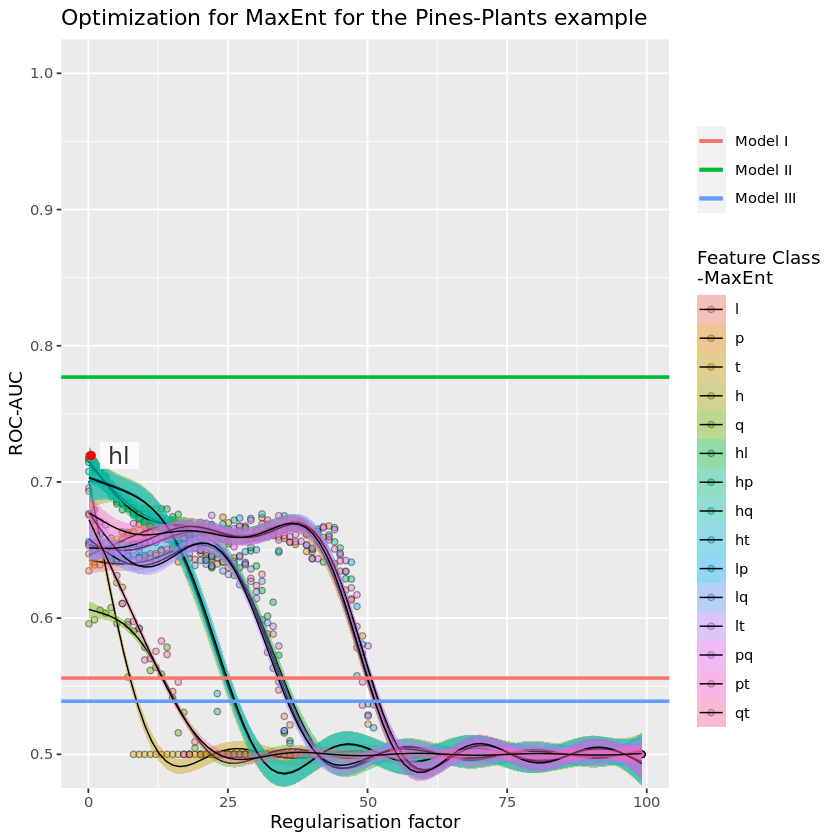

In [27]:
library(ggsci)
epsx = 5
epsy = 0.01
nonas = new[,2:16] %>% t %>% na.omit %>% t
opty = max(nonas) #- epsilon
optx = min(nonas) + epsx
py = max(nonas) #- epsilon
px = min(nonas) 
maxfeature = colnames(new)[colSums(nonas[,] == max(nonas)) > 0]
gg <- ggplot(data=all_data,aes(x=regs,y=value,fill=feature)) + 
    geom_point(colour="black",pch=21, size=1.5,alpha=0.4) +
    geom_smooth(method = "gam", formula = y ~s(x),colour='black',size=0.4)  +
    labs(x="Regularisation factor",y="ROC-AUC",colour="",fill = "Feature Class\n-MaxEnt") +
    ggtitle("Optimization for MaxEnt for the Pines-Plants example ") +

    annotate("point", colour="red",x = px, y = py,size=2,alpha=1) +    
    annotate("rect", fill="white",xmin = px + (epsx/3), xmax=px + (1.7*epsx),ymin= py - epsy,ymax= py + epsy,alpha=0.8) +

    annotate("text", x = optx, y = opty, label = maxfeature,size=5,colour='grey20') +
    ## Model 1
    geom_hline(aes(yintercept = M1mean,colour=M1name),size=1)  +
    #geom_ribbon(aes(ymin=M1low,ymax=M1high),fill='red',alpha=0.3,show.legend=FALSE) +
    ## Model 2
    geom_hline(aes(yintercept = M2mean,colour=M2name),size=1)  +
    #geom_ribbon(aes(ymin=M2low,ymax=M2high),fill='green',alpha=0.3,show.legend=FALSE) +
    ## Model 1
    geom_hline(aes(yintercept = M3mean,colour=M3name),size=1)  +
    coord_cartesian(ylim=c(0.5,1.0))
    #geom_ribbon(aes(ymin=M3low,ymax=M3high),fill='blue',alpha=0.3,show.legend=FALSE)
 
plot(gg)

In [9]:

m1 = models_birds[1,]
m2 = models_birds[2,]
m3 = models_birds[3,]
all_data <- data.frame()
for (i in seq(nrow(new))) {
    x <- new[i,] #,list(low=m1$low,mean=m1$mean,high=m1$high))
    M1 = list(M1low=m1$low,M1mean=m1$mean,M1high=m1$high,M1name=m1$names)
    M2 = list(M2low=m2$low,M2mean=m2$mean,M2high=m2$high,M2name=m2$names)
    M3 = list(M3low=m3$low,M3mean=m3$mean,M3high=m3$high,M3name=m3$names)
    M = list(M1,M2,M3)
    all_data <- rbind(all_data,cbind(x,M))
}

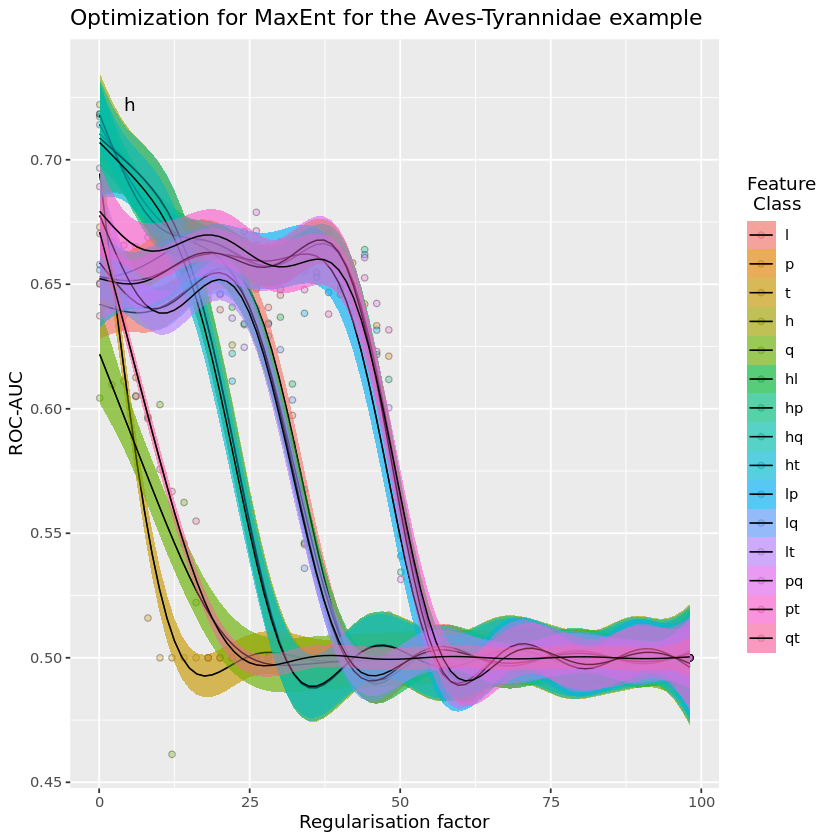

In [21]:
library(ggsci)

library(reshape)

new_flat <- melt(new,id.vars = 'regs')
colnames(new_flat) <- c('regs','feature','value')


epsx = 5
opty = max(new[-1]) #- epsilon
optx = min(new[1]) + epsx
maxfeature = colnames(new)[colSums(new[,] == max(new[-1])) > 0]
gg <- ggplot(data=new_flat,aes(x=regs,value,colour=feature,fill=feature)) + 
    geom_point(aes(fill=feature), colour="black",pch=21, size=1.5,alpha=0.3) +
    geom_smooth(method = "gam", formula = y ~s(x),colour='black',size=0.4)  +
    geom_smooth(method = "gam", formula = y ~s(x),colour='black',size=0.4)  +
    labs(x="Regularisation factor",y="ROC-AUC",colour="",fill = "Feature \n Class") +
    ggtitle("Optimization for MaxEnt for the Aves-Tyrannidae example ") +
    annotate("text", x = optx, y = opty, label = maxfeature) 
#    geom_hline(yintercept=models_pines[2,],color=models_pines[2,])
#    geom_hline(data = models_pines,
#                mapping = aes(yintercept = mean,colour=names),size=1)
plot(gg)

ERROR: Error in FUN(X[[i]], ...): object 'value' not found


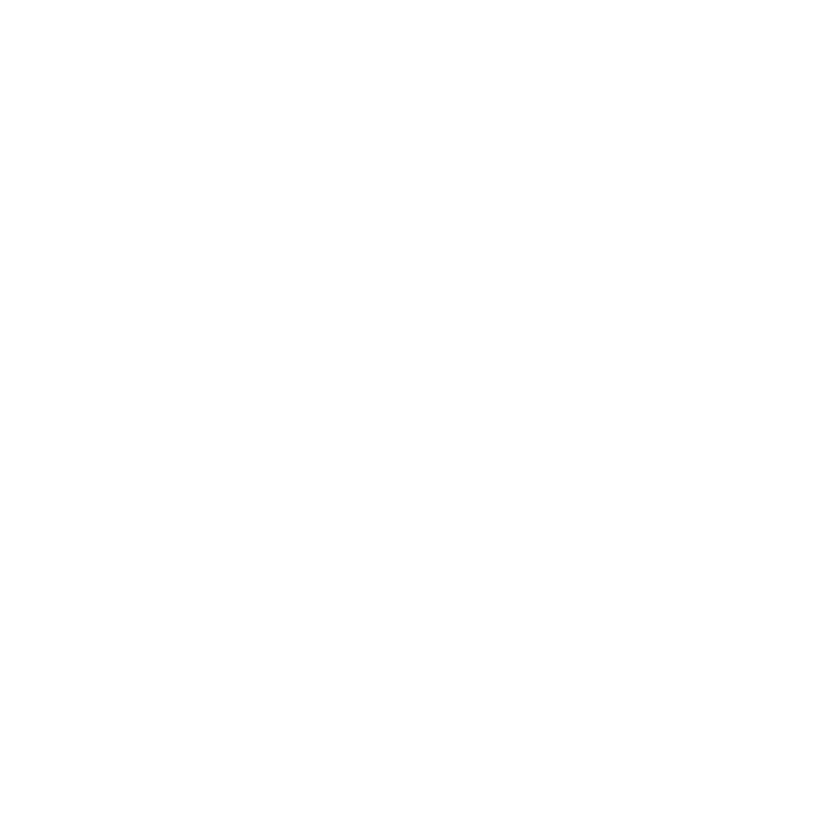

In [22]:
library(ggsci)
epsx = 5
epsy = 0.007 
opty = max(na.omit(new[-1])) #- epsilon
optx = min(na.omit(new[1])) + epsx
py = max(na.omit(new[-1])) #- epsilon
px = min(na.omit(new[1])) 
maxfeature = colnames(new)[colSums(new[,] == max(na.omit(new[-1]))) > 0]
gg <- ggplot(data=all_data,aes(x=regs,y=value,fill=feature)) + 
    geom_point(colour="black",pch=21, size=1.5,alpha=0.4) +
    geom_smooth(method = "gam", formula = y ~s(x),colour='black',size=0.4)  +
    labs(x="Regularisation factor",y="ROC-AUC",colour="",fill = "Feature Class\n-MaxEnt") +
    ggtitle("Optimization for MaxEnt for the Flycatchers - Birds example ") +

    annotate("point", colour="red",x = px, y = py,size=2,alpha=1) +    
    annotate("rect", fill="white",xmin = px + (epsx/3), xmax=px + (1.7*epsx),ymin= py - epsy,ymax= py + epsy,alpha=0.8) +

    annotate("text", x = optx, y = opty, label = maxfeature,size=5,colour='grey20') +
    ## Model 1
    geom_hline(aes(yintercept = M1mean,colour=M1name),size=1)  +
    #geom_ribbon(aes(ymin=M1low,ymax=M1high),fill='red',alpha=0.3,show.legend=FALSE) +
    ## Model 2
    geom_hline(aes(yintercept = M2mean,colour=M2name),size=1)  +
    #geom_ribbon(aes(ymin=M2low,ymax=M2high),fill='green',alpha=0.3,show.legend=FALSE) +
    ## Model 1
    #geom_hline(aes(yintercept = M3mean,colour=M3name),size=1)  +
    #coord_cartesian(ylim=c(0.5,1.0))
    #geom_ribbon(aes(ymin=M3low,ymax=M3high),fill='blue',alpha=0.3,show.legend=FALSE)
 
plot(gg)

In [30]:
ggsave(
  "/data/output/optim-birds.png",
  plot = last_plot(),
  device = NULL,
  path = NULL,
  scale = 1,
  width = NA,
  height = NA,
  units = c("in", "cm", "mm", "px"),
  dpi = 300,
  limitsize = TRUE,
  bg = NULL,
)

Saving 6.67 x 6.67 in image



mapping: ymin = ~low, ymax = ~high 
geom_ribbon: na.rm = FALSE, orientation = NA, outline.type = both
stat_identity: na.rm = FALSE
position_identity 

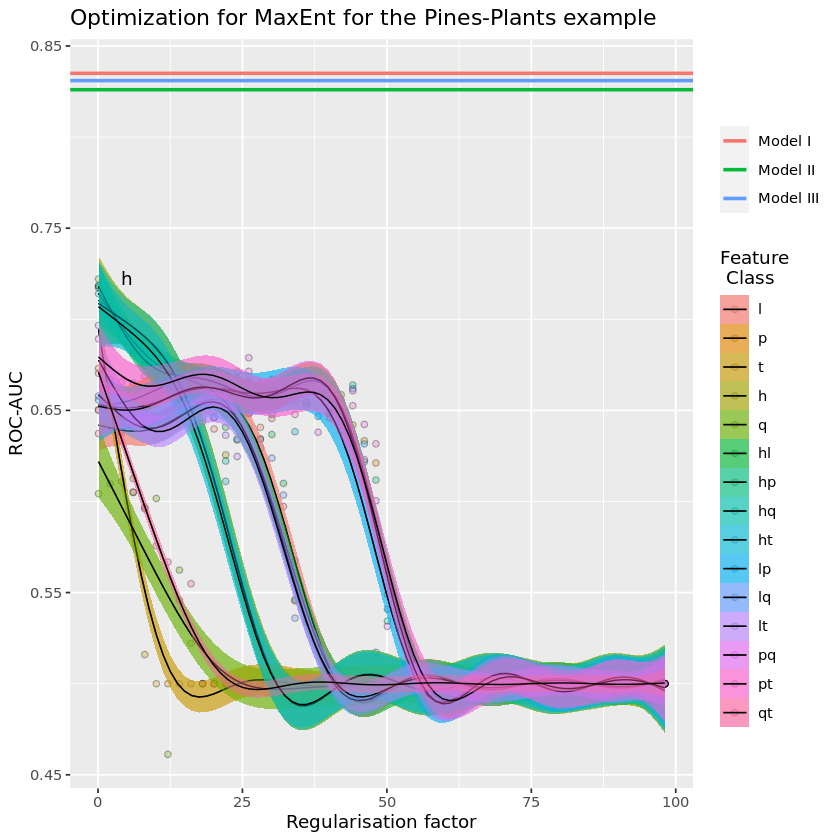

In [22]:
library(ggsci)
epsx = 5
opty = max(new[-1]) #- epsilon
optx = min(new[1]) + epsx
maxfeature = colnames(new)[colSums(new[,] == max(new[-1])) > 0]
gg <- ggplot(data=new_flat,aes(x=regs,value,colour=feature,fill=feature)) + 
    geom_point(aes(fill=feature), colour="black",pch=21, size=1.5,alpha=0.3) +
    geom_smooth(method = "gam", formula = y ~s(x),colour='black',size=0.4)  +
    geom_smooth(method = "gam", formula = y ~s(x),colour='black',size=0.4)  +
    labs(x="Regularisation factor",y="ROC-AUC",colour="",fill = "Feature \n Class") +
    ggtitle("Optimization for MaxEnt for the Pines-Plants example ") +
    annotate("text", x = optx, y = opty, label = maxfeature)  +
#    geom_hline(yintercept=models_pines[2,],color=models_pines[2,])
    geom_hline(data = models_pines,
                mapping = aes(yintercept = mean,colour=names),size=1)
    geom_ribbon(data=models_pines, mapping=aes(ymin=low,ymax=high),fill='red')
plot(gg)